<a href="https://colab.research.google.com/github/lukaszwojcik89/ml_codebrainers/blob/main/11b_Deep_Learning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN on CIFAR-10 dataset


In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from typing import Tuple
import requests
from PIL import Image
import io

In [2]:
# Ustawienie losowości dla powtarzalności eksperymentu
np.random.seed(42)
tf.random.set_seed(42)

def load_cifar10_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load the CIFAR-10 dataset and return train and test splits.
    CIFAR-10 consists of 50,000 training images and 10,000 test images,
    each image is 32x32x3 and a label from 0 to 9.

    Returns
    -------
    (X_train, y_train, X_test, y_test) : tuple of np.ndarray
        X_train: Training images
        y_train: Training labels
        X_test: Test images
        y_test: Test labels
    """
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
    return X_train, y_train, X_test, y_test


In [3]:
def create_validation_split(X: np.ndarray, y: np.ndarray, val_ratio: float = 0.1) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Create a validation split from the training data.
    By default, we take 10% of the training data for validation.

    Parameters
    ----------
    X : np.ndarray
        Training images
    y : np.ndarray
        Training labels
    val_ratio : float, optional
        Ratio of the training data to use for validation, by default 0.1

    Returns
    -------
    X_train_new, y_train_new, X_valid, y_valid : tuple of np.ndarray
        X_train_new: Training images after removing the validation split
        y_train_new: Training labels after removing the validation split
        X_valid: Validation images
        y_valid: Validation labels
    """
    num_val = int(len(X) * val_ratio)
    X_valid = X[:num_val]
    y_valid = y[:num_val]
    X_train_new = X[num_val:]
    y_train_new = y[num_val:]
    return X_train_new, y_train_new, X_valid, y_valid


In [4]:
def preprocess_data(X_train: np.ndarray, X_valid: np.ndarray, X_test: np.ndarray,
                    y_train: np.ndarray, y_valid: np.ndarray, y_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Preprocess the data by normalizing pixel values to [0,1] and one-hot encoding labels.

    Parameters
    ----------
    X_train, X_valid, X_test : np.ndarray
        Image data for training, validation, and test sets.
    y_train, y_valid, y_test : np.ndarray
        Label data for training, validation, and test sets.

    Returns
    -------
    (X_train_norm, X_valid_norm, X_test_norm, y_train_cat, y_valid_cat, y_test_cat) : tuple of np.ndarray
        Normalized and one-hot encoded datasets.
    """
    # Konwersja do float i normalizacja do [0,1]
    X_train_norm = X_train.astype('float32') / 255.0
    X_valid_norm = X_valid.astype('float32') / 255.0
    X_test_norm = X_test.astype('float32') / 255.0

    # One-hot encoding etykiet
    y_train_cat = to_categorical(y_train)
    y_valid_cat = to_categorical(y_valid)
    y_test_cat = to_categorical(y_test)

    return X_train_norm, X_valid_norm, X_test_norm, y_train_cat, y_valid_cat, y_test_cat

In [5]:
def show_sample_images(X: np.ndarray, y: np.ndarray, class_names: list, n_rows: int = 3, n_cols: int = 8):
    """
    Display a grid of sample images with their class labels.

    Parameters
    ----------
    X : np.ndarray
        Images dataset.
    y : np.ndarray
        Corresponding labels.
    class_names : list
        Class names for CIFAR-10.
    n_rows : int, optional
        Number of rows to display, by default 3.
    n_cols : int, optional
        Number of columns to display, by default 8.
    """
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X[index])
            plt.axis('off')
            plt.title(class_names[y[index][0]], fontsize=10)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()


In [6]:
def build_model(input_shape: tuple = (32,32,3), num_classes: int = 10) -> keras.models.Sequential:
    """
    Build and return a CNN model for CIFAR-10 classification.

    Parameters
    ----------
    input_shape : tuple, optional
        Shape of a single input image (height, width, channels).
    num_classes : int, optional
        Number of output classes, by default 10

    Returns
    -------
    model : keras.models.Sequential
        A compiled CNN model.
    """
    model = keras.models.Sequential([
        # Pierwsza warstwa konwolucyjna
        keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
        keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Kompilacja modelu
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def plot_history(history: keras.callbacks.History):
    """
    Plot training and validation loss and accuracy from a training history.

    Parameters
    ----------
    history : keras.callbacks.History
        History object from model.fit().
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
# Nazwy klas CIFAR-10
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [9]:
# 1. Wczytanie danych
X_train_full, y_train_full, X_test, y_test = load_cifar10_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [10]:
# 2. Tworzenie zbioru walidacyjnego ze zbioru treningowego
X_train, y_train, X_valid, y_valid = create_validation_split(X_train_full, y_train_full, val_ratio=0.1)

In [11]:
# 3. Preprocessing danych: normalizacja i one-hot encoding
X_train_norm, X_valid_norm, X_test_norm, y_train_cat, y_valid_cat, y_test_cat = preprocess_data(X_train, X_valid, X_test, y_train, y_valid, y_test)


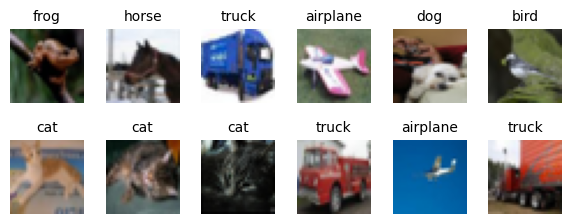

In [12]:
# Wyświetlenie przykładowych obrazków ze zbioru treningowego
show_sample_images(X_train, y_train, class_names, n_rows=2, n_cols=6)


In [13]:
# 4. Budowa modelu
model = build_model(input_shape=(32,32,3), num_classes=10)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 828,650 (3.16 MB)

 Trainable params: 828,650 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 5. Trening modelu z EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_norm, y_train_cat, epochs=30, batch_size=64, validation_data=(X_valid_norm, y_valid_cat), callbacks=[early_stopping])

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.3222 - loss: 1.8234 - val_accuracy: 0.5744 - val_loss: 1.1963
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5698 - loss: 1.2028 - val_accuracy: 0.6522 - val_loss: 0.9881
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6736 - loss: 0.9319 - val_accuracy: 0.7212 - val_loss: 0.8091
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7398 - loss: 0.7506 - val_accuracy: 0.7446 - val_loss: 0.7507
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7705 - loss: 0.6513 - val_accuracy: 0.7480 - val_loss: 0.7489
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8108 - loss: 0.5460 - val_accuracy: 0.7600 - val_loss: 0.7530
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8326 - loss: 0.4777 - val_accuracy: 0.7522 - val_loss: 0.8082
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8541 - loss: 0.4163 - val_accuracy

In [15]:
# 6. Ewaluacja modelu na zbiorze testowym
test_loss, test_acc = model.evaluate(X_test_norm, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 73.49%


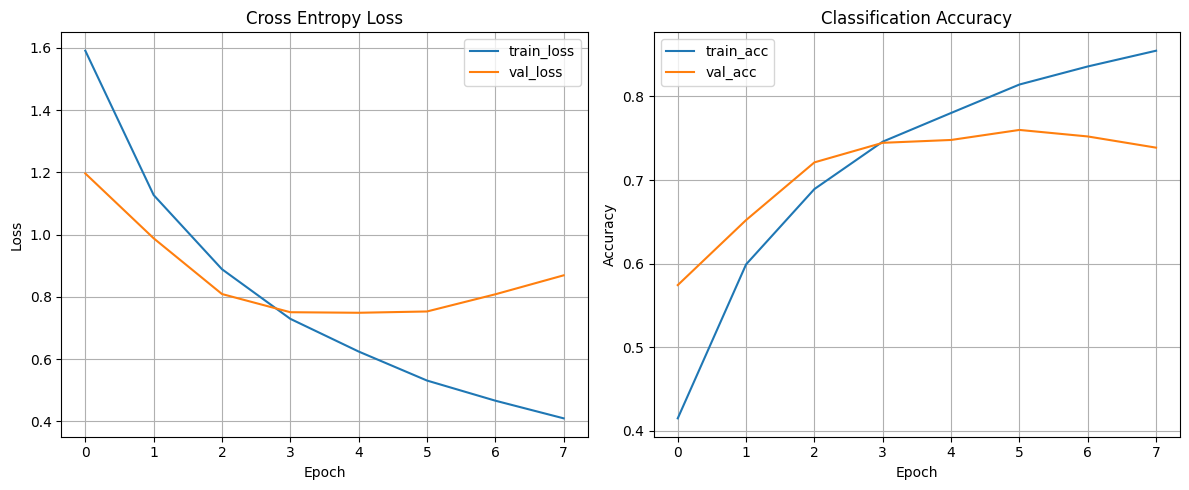

In [16]:
# 7. Wizualizacja historii treningu
plot_history(history)


In [20]:
def classify_image_from_url(model: keras.models.Sequential, url: str, class_names: list):
    """
    Download an image from a given URL, preprocess it to CIFAR-10 dimensions (32x32x3),
    predict its class using the provided model, and display the result.

    Parameters
    ----------
    model : keras.models.Sequential
        The trained model.
    url : str
        URL of the image to download.
    class_names : list
        Class names of CIFAR-10 for interpreting predictions.
    """
    # Pobranie obrazu z internetu
    response = requests.get(url)
    image_data = response.content
    img = Image.open(io.BytesIO(image_data))

    # Zmiana rozmiaru na 32x32 i konwersja do RGB
    img = img.resize((32,32)).convert('RGB')

    # Konwersja do numpy i normalizacja
    img_array = np.array(img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0) # [1,32,32,3]

    # Predykcja
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions, axis=-1)[0]
    predicted_class = class_names[class_index]

    # Wyświetlenie wyniku
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}", fontsize=14)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


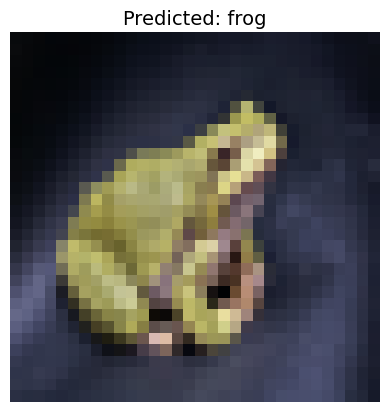

In [19]:
classify_image_from_url(model, 'https://images.twinkl.co.uk/tw1n/image/private/t_630/u/ux/frog-2_ver_1.jpg', class_names)